In [ ]:
# Install packages
# %pip install networkx
# %pip install numpy
# %pip install tqdm
# %pip install matplotlib

In [5]:
# The starter code is short and simple, take a look!
from starter import *
import itertools
import random
import math

# Phase 1 - Create Inputs

In [ ]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released

def np_int32_to_int(G: nx.Graph):
    for u, v, d in G.edges(data=True):
        d['weight'] = int(d['weight'])

def random_generate(G: nx.Graph):
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            edges.append((u, v))
    random.shuffle(edges)
    for u, v in edges[:min(MAX_EDGES, len(edges))]:
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    while sum(d for u, v, d in G.edges(data='weight')) < MIN_NET_WEIGHT:
        u, v = random.randint(0, G.number_of_nodes() - 1), random.randint(0, G.number_of_nodes() - 1)
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    np_int32_to_int(G)

def lopsided_generate(G: nx.Graph):
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            edges.append((u, v))
    edges = edges[:min(MAX_EDGES, len(edges))]
    for u, v in edges:
        G.add_edge(u, v, weight=random.randint(MAX_WEIGHT, MAX_WEIGHT))
    np_int32_to_int(G)
    
def scatter_close_generate(G: nx.Graph):
    node_pos = np.random.randint(0, 1000, (G.number_of_nodes(), 5))
    print(node_pos)
    max_edges_per_node = MAX_EDGES // G.number_of_nodes() - 3
    for u in range(G.number_of_nodes()):
        dist = [(v, np.linalg.norm(node_pos[u] - node_pos[v])) for v in range(G.number_of_nodes()) if u != v]
        dist.sort(key=lambda x: x[1])
        for v, w in dist[:5]:
            G.add_edge(u, v, weight=max(1, min(MAX_WEIGHT, int(round(w)))))
    while not nx.is_connected(G):
        dist = [(u, v, np.linalg.norm(node_pos[u] - node_pos[v])) for u, v in itertools.combinations(range(G.number_of_nodes()), 2) if u != v and not G.has_edge(u, v)]
        dist.sort(key=lambda x: x[2])
        for u, v, w in dist:
            G.add_edge(u, v, weight=max(1, min(MAX_WEIGHT, int(round(w)))))
            break
    print(G.number_of_edges())
    print(sum(d for u, v, d in G.edges(data='weight')))
    np_int32_to_int(G)

def triangle_circle_generate(G: nx.Graph):
    max_edges_per_node = MAX_EDGES // G.number_of_nodes()
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, u + max_edges_per_node + 1):
            edges.append((u, v % G.number_of_nodes()))
    for u, v in edges:
        G.add_edge(u, v, weight=random.randint(1, max(u, v)))
    np_int32_to_int(G)

def random_prior_generate(G: nx.Graph):
    max_edges_per_node = MAX_EDGES // G.number_of_nodes()
    for u in range(max_edges_per_node, G.number_of_nodes()):
        vs = random.sample(range(u), max_edges_per_node)
        for v in vs:
            G.add_edge(u, v, weight=random.randint(max(min(u, v), 1), max(u, v)))
    for u, v in itertools.combinations(range(max_edges_per_node), 2):
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(max(min(u, v), 1), max(u, v)))

def multiply_generate(G: nx.Graph):
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            if (u + 1) * (v + 1) % MAX_WEIGHT > 0:
                G.add_edge(u, v, weight=(u + 1) * (v + 1) % MAX_WEIGHT)

def small(G: nx.Graph):
    multiply_generate(G)

def medium(G: nx.Graph):
    random_prior_generate(G)

def large(G: nx.Graph):
    triangle_circle_generate(G)

def hw11_6c(dim = 4):
    G = nx.empty_graph(dim * dim)
    for i in range(dim):
        for j in range(dim):
            if i > 0:
                G.add_edge(i * dim + j, (i - 1) * dim + j, weight=1)
            if j > 0:
                G.add_edge(i * dim + j, i * dim + j - 1, weight=1)
    np_int32_to_int(G)
    return G

In [ ]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, '../tests/small/multiply/')

# G = nx.empty_graph(N_MEDIUM)
# medium(G)
# write_input(G, '../tests/medium/prior/')

# G = nx.empty_graph(N_LARGE)
# large(G)
# write_input(G, '../tests/large/circle/')

# Phase 2 - Implement your Solver

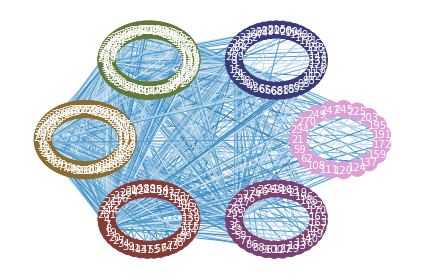

1055001.852892617

In [39]:
IN_FILE = '../tests/medium/medium77/'

def copy_teams(G: nx.Graph, G_copy: nx.Graph):
    for v in G:
        G.nodes[v]['team'] = G_copy.nodes[v]['team']

def random_solve(G: nx.Graph, team_size = 10):
    for v in G:
        G.nodes[v]['team'] = random.randint(1, random.randint(1, team_size))

def random_sample_solve(G: nx.Graph):
    G_best, best_score = G.copy(), float('inf')
    for _ in range(1000):
        random_solve(G)
        new_score = score(G)
        if new_score < best_score:
            G_best, best_score = G.copy(), new_score
    copy_teams(G, G_best)

def basic_three_color_solve(G: nx.Graph):
    colors = nx.coloring.greedy_color(G, strategy='DSATUR')
    for v in G:
        G.nodes[v]['team'] = colors[v]+1
    
def solve(G: nx.Graph):
    basic_three_color_solve(G)
    
def score_to_str(score: float):
    return str(round(score))

def write_output_general(G: nx.Graph, path: str, overwrite=False, copy=True, suffix=''):
    if suffix != '':
        suffix = '_' + suffix
    write_output(G, path + '{}{}.out'.format(score_to_str(score(G)), suffix), overwrite=overwrite, copy=copy)

def visualize_general(G: nx.Graph, path: str, overwrite=False, copy=True, suffix=''):
    if suffix != '':
        suffix = '_' + suffix
    visualize(G, path + '{}{}.png'.format(score_to_str(score(G)), suffix))

G = read_input(IN_FILE + 'graph.in')
solve(G)
validate_output(G)
run_type = 'rand'
write_output_general(G, IN_FILE, overwrite=True, suffix=run_type)
visualize_general(G, IN_FILE, suffix=run_type)
score(G)

In [ ]:
run_all(solve, '../tests/', '../submission/', overwrite=True)
tar('../phase_2/', path='../submission.tar')

# Custom Visualizer

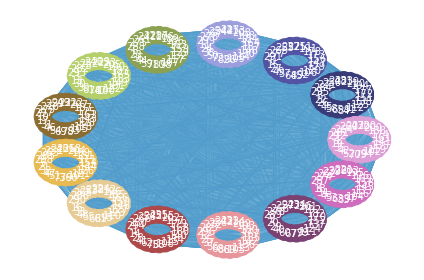

366095.4145999371

In [8]:
FILE = '366095_boss_battle_int'
TEST_FOLDER = '../tests/medium/medium13/'
IN_FILE = TEST_FOLDER + 'graph.in'
OUT_FILE = TEST_FOLDER + FILE + '.out'
G = read_input(IN_FILE)
read_output(G, OUT_FILE)
validate_output(G)
visualize(G)
score(G)

In [ ]:
G = read_input('../tests/large/large204/graph.in')

G.nodes[0]['team'] = 1
G.nodes[1]['team'] = 2
G.nodes[2]['team'] = 3
G.nodes[3]['team'] = 3

counts = [1, 1, 2, 0]

for v in range(4, 300):
    G.nodes[v]['team'] = 4
    counts[3] += 1

for v in range(300, 1000):
    team = np.argmin(counts)
    G.nodes[v]['team'] = team + 1
    counts[team] += 1

for u, v in G.edges:
    if G.nodes[u]['team'] == G.nodes[v]['team']:
        print(u, v, G.edges[u, v]['weight'])

visualize(G)
print([v['team'] for v in G.nodes.values()])
print(score(G, separated=True))
score(G)

In [ ]:
G = read_input('../tests/large/large191/graph.in')

def get_components(G: nx.Graph):
    components = []
    visited = set()
    for v in G:
        if v in visited:
            continue
        visited.add(v)
        component = [v]
        queue = [v]
        while len(queue) > 0:
            u = queue.pop()
            for v in G[u]:
                if v not in visited:
                    visited.add(v)
                    component.append(v)
                    queue.append(v)
        components.append(component)
    return components

def three_color_solve(G: nx.Graph):
    colors = nx.coloring.greedy_color(G, strategy='DSATUR')
    for v in [0, 250, 350, 450, 550, 650, 750, 850, 950, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 800, 900]:
        G.nodes[v]['team'] = colors[v]+1
    counts = [0, 0, 0]
    for v in G:
        if 'team' in G.nodes[v]:
            counts[G.nodes[v]['team']-1] += 1
    for v in G:
        if 'team' not in G.nodes[v]:
            team = np.argmin(counts)
            G.nodes[v]['team'] = team + 1
            counts[team] += 1

three_color_solve(G)

for u, v in G.edges:
    if G.nodes[u]['team'] == G.nodes[v]['team']:
        print(u, v, G.edges[u, v]['weight'])

visualize(G)
print([v['team'] for v in G.nodes.values()])
print(score(G, separated=True))
score(G)

In [45]:
def team_upperbound(score):
    return math.floor(math.log(score / K_COEFFICIENT) / K_EXP);


In [46]:
team_upperbound(700)

3